# Explain Black Box

In [27]:
import torch
from torch.autograd import Variable
from torchvision import models

import cv2
import sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [67]:
# hyper parameters
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2

In [68]:
def load_model():
    model = models.vgg19(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()
    
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

model = load_model()

In [81]:
# BGR => RGB
original_img = cv2.imread('data/cat.jpg', 1)[:, :, ::-1]

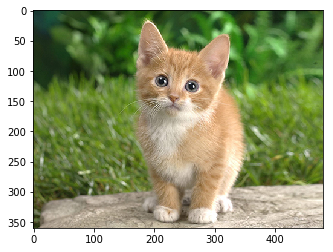

In [82]:
plt.imshow(original_img)

In [83]:
original_img = cv2.resize(original_img, (224, 224))

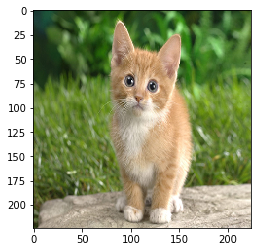

In [84]:
plt.imshow(original_img)

In [85]:
img = np.float32(original_img) / 255

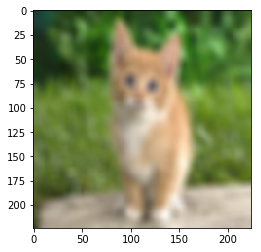

In [86]:
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
plt.imshow(blurred_img1)

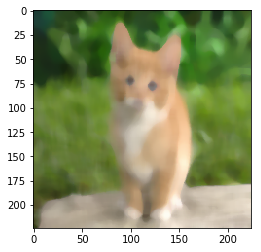

In [87]:
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11)) / 255
plt.imshow(blurred_img2)

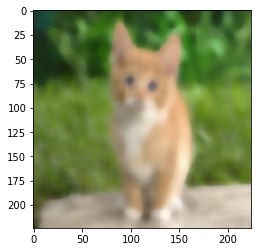

In [88]:
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
plt.imshow(blurred_img_numpy)

In [89]:
mask_init = np.ones((28, 28), dtype=np.float32)

In [90]:
def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]

    # (shape, height, width)
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    
    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)
    
    preprocessed_img_tensor.unsqueeze_(0)

    return Variable(preprocessed_img_tensor, requires_grad=False)

In [91]:
# convert to torch variables
img = preprocess_image(img)
blurred_img = preprocess_image(blurred_img2)

print(img.size())
print(blurred_img.size())

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [93]:
def numpy_to_torch(img, requires_grad=True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        # (shape, height, width)
        output = np.transpose(img, (2, 0, 1))
    
    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()
    
    output.unsqueeze_(0)
    v = Variable(output, requires_grad=requires_grad)
    return v

In [124]:
# 入力画像を (224, 224) のサイズに拡大
# upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))  # deprecated
upsample = torch.nn.Upsample(size=(224, 224), mode='bilinear')
if use_cuda:
    upsample = upsample.cuda()

In [125]:
upsample

Upsample(size=(224, 224), mode=bilinear)

In [111]:
# 1000クラスの出力をsoftmaxに通して確率にする
target = torch.nn.Softmax(dim=1)(model(img))

In [112]:
category = np.argmax(target.cpu().data.numpy())

In [113]:
category

285

In [118]:
import json
class_index = json.load(open('data/imagenet_class_index.json', 'r'))
labels = {int(key):value for (key, value) in class_index.items()}

In [119]:
print(labels[category])

['n02124075', 'Egyptian_cat']


In [120]:
print('Category with highest probability', category, labels[category])
print('Optimizing..')

Category with highest probability 285 ['n02124075', 'Egyptian_cat']
Optimizing..


In [127]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1, :] - img[1:, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[:, :-1] - img[:, 1:])).pow(tv_beta))
    return row_grad + col_grad

In [169]:
# 更新対象のパラメータはmask
optimizer = torch.optim.Adam([mask], lr=learning_rate)

In [170]:
mask = numpy_to_torch(mask_init)
mask.size()

torch.Size([1, 1, 28, 28])

In [ ]:
for i in range(max_iterations):
    # 28x28のマスクを224x224に拡大
    upsampled_mask = upsample(mask)

    # マスクはRGB画像としたいため3チャンネルに拡張
    upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2), upsampled_mask.size(3))
    
    # maskの比率でオリジナルの画像とブラー画像を足し合わせている
    # 初期値はmask=1なのでオリジナル画像にしかならない
    # Use the mask to perturbated the input image
    perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1 - upsampled_mask)

    # 画像にランダムノイズを加える
    noise = 0.2 * np.random.randn(224, 224, 3).astype(np.float32)
    noise = numpy_to_torch(noise)
    perturbated_input = perturbated_input + noise

    outputs = torch.nn.Softmax(dim=1)(model(perturbated_input))
    # maskがパラメータの更新対象となる
    loss = l1_coeff * torch.mean(torch.abs(1 - mask)) + tv_coeff * tv_norm(mask, tv_beta) + outputs[0, category]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    mask.data.clamp_(0, 1)
    print(i, loss.data[0])